In [73]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import math
import string
import random
from utils import get_reward_model, get_score, get_scores_df, get_percent_chosen
from nltk.corpus import wordnet as wn
# from textblob import TextBlob
import matplotlib.pyplot as plt
import scipy.stats as st

In [10]:
def get_perturbed_scores(path: str):
    perturbed_scores = {}
    pprob = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    experiments = ['prompt_and_response','prompt', 'response']
    for e in experiments:
        perturbed_scores[e] = {}
        for pp in pprob:
            df = pd.read_csv(path + '/' + e + '/' + str(pp).replace('.','') + '_scores.csv')
            perturbed_scores[e][pp] = df
    return perturbed_scores

In [161]:
def get_accs(perturbed_scores):
    probs_both, accs_both = [], []
    for k,v in perturbed_scores['prompt_and_response'].items():
        probs_both.append(k)
        accs_both.append(get_percent_chosen(v))
    probs_prompt, accs_prompt = [], []
    for k,v in perturbed_scores['prompt'].items():
        probs_prompt.append(k)
        accs_prompt.append(get_percent_chosen(v))
    probs_response, accs_response = [], []
    for k,v in perturbed_scores['response'].items():
        probs_response.append(k)
        accs_response.append(get_percent_chosen(v))

    return [accs_both, accs_prompt, accs_response]

def get_eces(perturbed_scores):
    eces_both = []
    confs_both = []
    for k, v in perturbed_scores['prompt_and_response'].items():
        scores = softmax(v.values, axis=1)
        y_true = np.array([0] * len(scores)) # chosen is always class 0
        preds = scores.argmax(axis=1)
        confs = scores[np.arange(len(scores)), preds]
        ece, _, _ = get_metrics(y_true=y_true, preds=preds, confs=confs)
        eces_both.append(ece)
        confs_both.append(np.mean(confs))
    
    eces_prompt = []
    confs_prompt = []
    for k, v in perturbed_scores['prompt'].items():
        scores = softmax(v.values, axis=1)
        y_true = np.array([0] * len(scores)) # chosen is always class 0
        preds = scores.argmax(axis=1)
        confs = scores[np.arange(len(scores)), preds]
        ece, _, _ = get_metrics(y_true=y_true, preds=preds, confs=confs)
        eces_prompt.append(ece)
        confs_prompt.append(np.mean(confs))
        
    eces_response = []
    confs_response = []
    for k, v in perturbed_scores['response'].items():
        scores = softmax(v.values, axis=1)
        y_true = np.array([0] * len(scores)) # chosen is always class 0
        preds = scores.argmax(axis=1)
        confs = scores[np.arange(len(scores)), preds]
        ece, _, _ = get_metrics(y_true=y_true, preds=preds, confs=confs)
        eces_response.append(ece)
        confs_response.append(np.mean(confs))
    
    return [eces_both, eces_prompt, eces_response], [confs_both, confs_prompt, confs_response]

In [162]:
perturbed_scores1 = get_perturbed_scores('model_scores/deberta_v3_large/open_ai_summarize_from_feedback')
perturbed_scores2 = get_perturbed_scores('trial2')
accs1 = get_accs(perturbed_scores1)
accs2 = get_accs(perturbed_scores2)
eces1, confs1 = get_eces(perturbed_scores1)
eces2, confs2 = get_eces(perturbed_scores2)

In [94]:
accs_avg_both = []
accs_error_both = []
for idx, acc in enumerate(accs1[0]):
    accs_avg_both.append((acc + accs2[0][idx])/2)
    accs_error_both.append(abs(acc - accs2[0][idx])/2)

accs_avg_prompt = []
accs_error_prompt = []
for idx, acc in enumerate(accs1[1]):
    accs_avg_prompt.append((acc + accs2[1][idx])/2)
    accs_error_prompt.append(abs(acc - accs2[1][idx])/2)
    
accs_avg_response = []
accs_error_response = []
for idx, acc in enumerate(accs1[2]):
    accs_avg_response.append((acc + accs2[2][idx])/2)
#     gfg_data = [acc, accs2[2][idx]]
#     conf = st.t.interval(confidence=0.95, df=len(gfg_data)-1,
#               loc=np.mean(gfg_data),
#               scale=st.sem(gfg_data))
    accs_error_response.append(abs(acc - accs2[2][idx])/2)

In [132]:
eces_avg_both = []
eces_error_both = []
for idx, ece in enumerate(eces1[0]):
    eces_avg_both.append((ece + eces2[0][idx])/2)
    eces_error_both.append(abs(ece - eces2[0][idx])/2)

eces_avg_prompt = []
eces_error_prompt = []
for idx, ece in enumerate(eces1[1]):
    eces_avg_prompt.append((ece + eces2[1][idx])/2)
    eces_error_prompt.append(abs(ece - eces2[1][idx])/2)
    
eces_avg_response = []
eces_error_response = []
for idx, ece in enumerate(eces1[2]):
    eces_avg_response.append((ece + eces2[2][idx])/2)
#     gfg_data = [acc, accs2[2][idx]]
#     conf = st.t.interval(confidence=0.95, df=len(gfg_data)-1,
#               loc=np.mean(gfg_data),
#               scale=st.sem(gfg_data))
    eces_error_response.append(abs(ece - eces2[2][idx])/2)

In [166]:
confs_avg_both = []
confs_error_both = []
for idx, conf in enumerate(confs1[0]):
    confs_avg_both.append((conf + confs2[0][idx])/2)
    confs_error_both.append(abs(conf - confs2[0][idx])/2)

confs_avg_prompt = []
confs_error_prompt = []
for idx, conf in enumerate(confs1[1]):
    confs_avg_prompt.append((conf + confs2[1][idx])/2)
    confs_error_prompt.append(abs(conf - confs2[1][idx])/2)
    
confs_avg_response = []
confs_error_response = []
for idx, conf in enumerate(confs1[2]):
    confs_avg_response.append((conf + confs2[2][idx])/2)
#     gfg_data = [acc, accs2[2][idx]]
#     conf = st.t.interval(confidence=0.95, df=len(gfg_data)-1,
#               loc=np.mean(gfg_data),
#               scale=st.sem(gfg_data))
    confs_error_response.append(abs(conf - confs2[2][idx])/2)

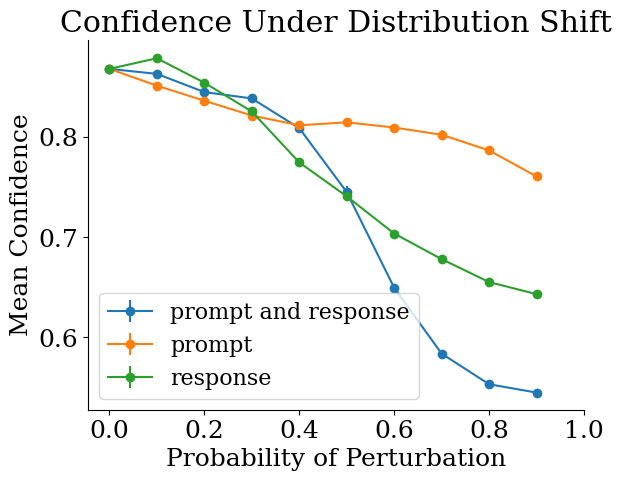

In [167]:
font = {'family': 'serif',
        'weight': 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
ax = plt.subplot()
plt.errorbar(probs_both, confs_avg_both, yerr = confs_error_both, marker='o', label='prompt and response')
plt.errorbar(probs_both, confs_avg_prompt, yerr = confs_error_prompt, marker='o', label='prompt')
plt.errorbar(probs_both, confs_avg_response, yerr = confs_error_response, marker='o', label='response')
#plt.ylim(0.4, 0.8)
plt.xlabel('Probability of Perturbation')
plt.xticks(np.arange(0, 1.2, step=0.2))
plt.ylabel('Mean Confidence')
plt.title('Confidence Under Distribution Shift')
plt.legend(prop={'size': 16})
ax.spines[['right', 'top']].set_visible(False)

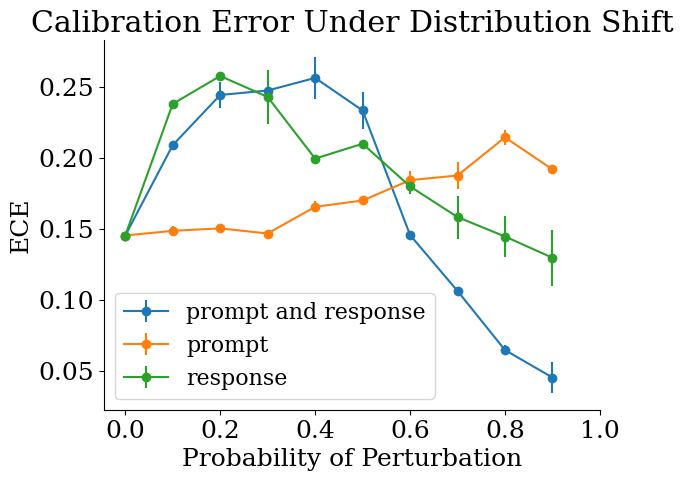

In [139]:
font = {'family': 'serif',
        'weight': 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
ax = plt.subplot()
plt.errorbar(probs_both, eces_avg_both, yerr = eces_error_both, marker='o', label='prompt and response')
plt.errorbar(probs_both, eces_avg_prompt, yerr = eces_error_prompt, marker='o', label='prompt')
plt.errorbar(probs_both, eces_avg_response, yerr = eces_error_response, marker='o', label='response')
#plt.ylim(0.4, 0.8)
plt.xlabel('Probability of Perturbation')
plt.xticks(np.arange(0, 1.2, step=0.2))
plt.ylabel('ECE')
plt.title('Calibration Error Under Distribution Shift')
plt.legend(prop={'size': 16})
ax.spines[['right', 'top']].set_visible(False)

In [96]:
import matplotlib

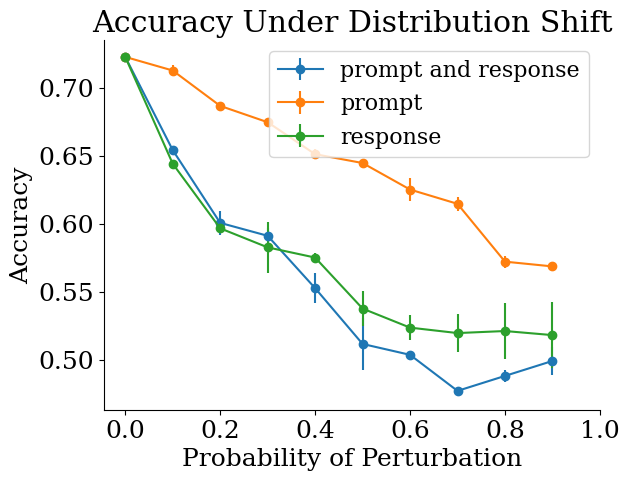

In [114]:
font = {'family': 'serif',
        'weight': 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
ax = plt.subplot()
plt.errorbar(probs_both, accs_avg_both, yerr = accs_error_both, marker='o', label='prompt and response')
plt.errorbar(probs_both, accs_avg_prompt, yerr = accs_error_prompt, marker='o', label='prompt')
plt.errorbar(probs_both, accs_avg_response, yerr = accs_error_response, marker='o', label='response')
#plt.ylim(0.4, 0.8)
plt.xlabel('Probability of Perturbation')
plt.xticks(np.arange(0, 1.2, step=0.2))
plt.ylabel('Accuracy')
plt.title('Accuracy Under Distribution Shift')
plt.legend(prop={'size': 16})
ax.spines[['right', 'top']].set_visible(False)

In [117]:
def calc_bins(y_true, preds, confs, num_bins=10):
  # Assign each prediction to a bin
    bins = np.linspace(1.0 / num_bins, 1, num_bins)
    binned = np.digitize(confs, bins)

    # Save the accuracy, confidence and size of each bin
    bin_accs = np.zeros(num_bins)
    bin_confs = np.zeros(num_bins)
    bin_sizes = np.zeros(num_bins)

    for bin in range(num_bins):
        bin_sizes[bin] = len(preds[binned == bin])
        if bin_sizes[bin] > 0:
            bin_accs[bin] = np.mean(y_true[binned==bin] == preds[binned == bin])
            bin_confs[bin] = np.mean(confs[binned==bin])

    return bins, binned, bin_accs, bin_confs, bin_sizes

def get_metrics(y_true, preds, confs):
    ECE = 0
    MCE = 0
    bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(y_true, preds, confs)

    for i in range(len(bins)):
        abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
        ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
        MCE = max(MCE, abs_conf_dif)

    overall_acc = np.mean(y_true == preds)
    return ECE, MCE, overall_acc
  
def draw_reliability_graph(y_true, preds, confs, save_path, title=None):
    ECE, MCE, overall_acc = get_metrics(y_true, preds, confs)
    bins, _, bin_accs, _, _ = calc_bins(y_true, preds, confs)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()

    # x/y limits
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1)

    # x/y labels
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')

    # Create grid
    ax.set_axisbelow(True) 
    ax.grid(color='gray', linestyle='dashed')

    # Error bars
    plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

    # Draw bars and identity line
    plt.bar(bins, bin_accs, width=0.1, alpha=0.7, edgecolor='red', color='purple')
    plt.bar(bins, np.minimum(bins,bin_accs), width=0.1, alpha=1, edgecolor='black', color='b')

    plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

    # Equally spaced axes
    plt.gca().set_aspect('equal', adjustable='box')

    # ECE and MCE legend
    ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
    #MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
    #acc_patch = mpatches.Patch(color='orange', label='Overall Accuracy = {:.2f}%'.format(overall_acc*100))
    plt.legend(handles=[ECE_patch])
    if title is not None:
        plt.title(title)
    fig.savefig(save_path)

In [144]:
from scipy.special import softmax
from scipy.special import logsumexp
scores = perturbed_scores1['prompt_and_response'][0.6]
scores = softmax(scores.values, axis=1)
y_true = np.array([0] * len(scores)) # chosen is always class 0
preds = scores.argmax(axis=1)
confs = scores[np.arange(len(scores)), preds]
ece, mce, acc = get_metrics(y_true=y_true, preds=preds, confs=confs)

In [181]:
from scipy.special import logsumexp
scores = perturbed_scores1['prompt_and_response'][0.6]
scores = logsumexp(scores.values, axis=1)

In [186]:
scores

array([-3.81777746, -5.18439091, -4.01409313, -5.24813532, -5.22234408,
       -2.50454838, -5.38645678, -0.05088597, -5.35403705, -5.73780269,
       -5.12040854, -5.66904095, -4.8377551 , -3.79580002, -5.02519158,
       -4.08037296, -5.30470894, -4.15958408, -2.85138422, -5.7548394 ,
       -5.81551443, -4.82515004, -2.97679479, -4.88605386, -5.3477022 ,
       -4.44371455, -5.48560186, -5.51637475, -4.90192226, -3.63048109,
       -5.99746041, -5.70274525, -4.89455226, -5.5728863 , -5.27335641,
       -4.62652312, -4.96757309, -3.15042996, -3.14258058, -4.94224141,
       -5.57553936, -5.51771813, -5.16441223, -5.16227939, -5.35892055,
       -4.29596432, -4.51758357, -4.97336052, -5.38757378, -5.05878542,
       -5.07712797, -5.99101329, -5.01487019, -4.6772797 , -5.19638328,
       -4.92307066,  0.6616906 , -4.38747275, -2.42060149, -5.8543231 ,
       -4.53772743, -5.18199405, -4.51389025, -5.32540006, -4.80854955,
       -4.69977221, -4.65444924, -4.87082993, -5.70649266, -5.00

In [157]:
np.mean(confs)

0.6487631774896688

In [171]:
scores

array([[0.55676157, 0.44323843],
       [0.59526086, 0.40473914],
       [0.64351834, 0.35648166],
       ...,
       [0.53342761, 0.46657239],
       [0.22793355, 0.77206645],
       [0.50575434, 0.49424566]])